In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from skimage.feature import local_binary_pattern

In [2]:
# Function to convert RGB image to HSI
def rgb_to_hsi(image):
    hsi_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return hsi_image

# Function for GrabCut segmentation
def segment_tyre(image):
    # Convert image to HSI
    hsi_image = rgb_to_hsi(image)

    # Extract hue component
    hue = hsi_image[:, :, 0]

    # Thresholding on hue channel to separate tyre from background
    _, binary_mask = cv2.threshold(hue, 30, 255, cv2.THRESH_BINARY)

    # Perform morphological operations to refine the mask
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark watershed boundary on original image

    # Convert markers to binary mask
    mask = np.zeros_like(binary_mask)
    mask[markers > 1] = 255  # Mark region other than background

    # Apply the mask to original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

# Function for LBP feature extraction
def extract_features(image):
    
    hsi_image = rgb_to_hsi(image)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Compute Local Binary Pattern
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Calculate histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    return hist

# Function to load images from folders
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
# Load good and  Defective Tyre images
good_folder = r"C:\Users\dubey\OneDrive\Desktop\Diat Tire Classification Paper Written\tyre classification using svm\good tyre image"
defective_folder = r"C:\Users\dubey\OneDrive\Desktop\Diat Tire Classification Paper Written\tyre classification using svm\defective tyre image"

good_images = load_images_from_folder(good_folder)
defective_images = load_images_from_folder(defective_folder)

# Segment and extract features for good images
good_features = []
for img in good_images:
    segmented_img = segment_tyre(img)
    features = extract_features(segmented_img)
    good_features.append(features)

# Segment and extract features for defective images
defective_features = []
for img in defective_images:
    segmented_img = segment_tyre(img)
    features = extract_features(segmented_img)
    defective_features.append(features)

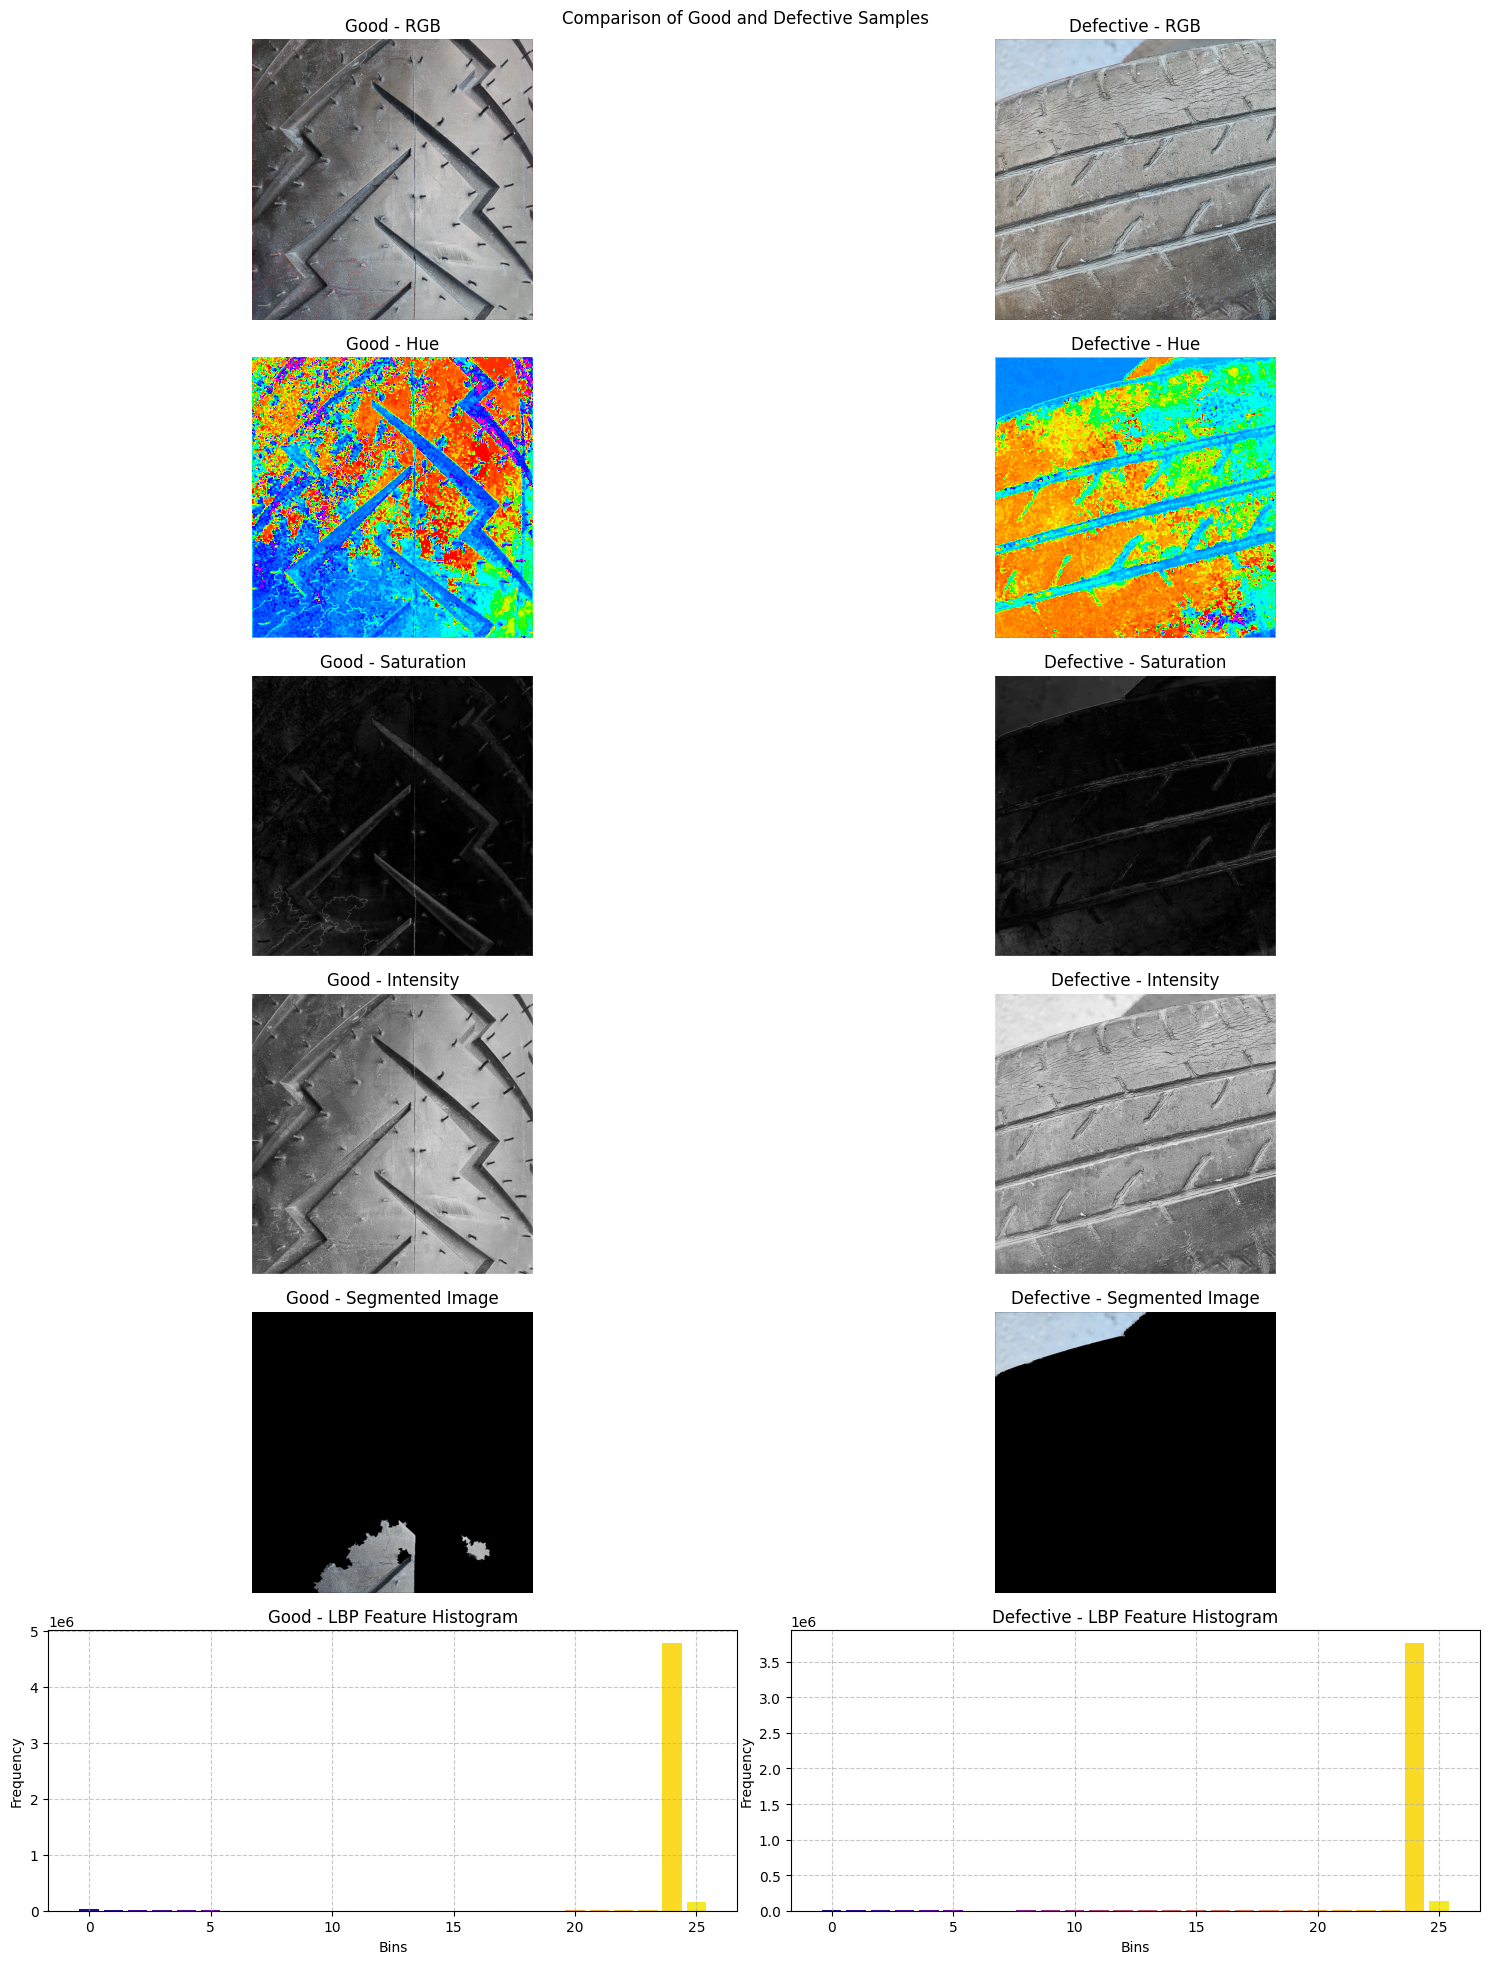

In [4]:
# Function to visualize HSI conversion and extracted features for a sample image
def visualize_samples(good_image, defective_image):
    fig, axes = plt.subplots(6, 2, figsize=(15, 20))

    # Visualize good image
    axes[0, 0].imshow(good_image)
    axes[0, 0].set_title('Good - RGB')
    axes[0, 0].axis('off')

    axes[1, 0].imshow(rgb_to_hsi(good_image)[:, :, 0], cmap='hsv')
    axes[1, 0].set_title('Good - Hue')
    axes[1, 0].axis('off')

    axes[2, 0].imshow(rgb_to_hsi(good_image)[:, :, 1], cmap='gray')
    axes[2, 0].set_title('Good - Saturation')
    axes[2, 0].axis('off')

    axes[3, 0].imshow(rgb_to_hsi(good_image)[:, :, 2], cmap='gray')
    axes[3, 0].set_title('Good - Intensity')
    axes[3, 0].axis('off')

    segmented_img_good = segment_tyre(good_image)
    features_good = extract_features(segmented_img_good)

    axes[4, 0].imshow(segmented_img_good)
    axes[4, 0].set_title('Good - Segmented Image')
    axes[4, 0].axis('off')

    num_bins_good = len(features_good)
    colors_good = sns.color_palette("plasma", num_bins_good)

    axes[5, 0].bar(range(num_bins_good), features_good, color=colors_good)
    axes[5, 0].set_title('Good - LBP Feature Histogram')
    axes[5, 0].set_xlabel('Bins')
    axes[5, 0].set_ylabel('Frequency')
    axes[5, 0].grid(True, linestyle='--', alpha=0.7)

    # Visualize defective image
    axes[0, 1].imshow(defective_image)
    axes[0, 1].set_title('Defective - RGB')
    axes[0, 1].axis('off')

    axes[1, 1].imshow(rgb_to_hsi(defective_image)[:, :, 0], cmap='hsv')
    axes[1, 1].set_title('Defective - Hue')
    axes[1, 1].axis('off')

    axes[2, 1].imshow(rgb_to_hsi(defective_image)[:, :, 1], cmap='gray')
    axes[2, 1].set_title('Defective - Saturation')
    axes[2, 1].axis('off')

    axes[3, 1].imshow(rgb_to_hsi(defective_image)[:, :, 2], cmap='gray')
    axes[3, 1].set_title('Defective - Intensity')
    axes[3, 1].axis('off')

    segmented_img_defective = segment_tyre(defective_image)
    features_defective = extract_features(segmented_img_defective)

    axes[4, 1].imshow(segmented_img_defective)
    axes[4, 1].set_title('Defective - Segmented Image')
    axes[4, 1].axis('off')

    num_bins_defective = len(features_defective)
    colors_defective = sns.color_palette("plasma", num_bins_defective)

    axes[5, 1].bar(range(num_bins_defective), features_defective, color=colors_defective)
    axes[5, 1].set_title('Defective - LBP Feature Histogram')
    axes[5, 1].set_xlabel('Bins')
    axes[5, 1].set_ylabel('Frequency')
    axes[5, 1].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle("Comparison of Good and Defective Samples")
    plt.tight_layout()
    plt.show()

# Visualize a sample image from the good dataset and the defective dataset
visualize_samples(good_images[0], defective_images[0])

In [5]:
# Create dataframes for Good  and Defective features
good_df = pd.DataFrame(good_features)
defective_df = pd.DataFrame(defective_features)

# Label good as 0 and defective as 1
good_df['label'] = 0
defective_df['label'] = 1

# Combine dataframes
df = pd.concat([good_df, defective_df], ignore_index=True)

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,32883,10233,13003,12046,8545,5540,3887,3141,2725,2633,...,2380,2826,3478,5133,8604,12435,12529,4709693,191451,0
1,140813,57451,57637,47032,36504,29274,24910,23000,23536,25516,...,20258,19521,23234,31500,46382,59823,57191,3010634,1038621,0
2,28911,17702,14206,11188,9498,8332,7585,8575,9103,10844,...,8304,7398,7782,8900,12324,16168,17631,2596699,345066,0
3,52106,20523,20861,19183,17275,16168,15802,16922,18607,21967,...,13248,11956,12776,14233,18468,21955,19960,4146059,392062,0
4,77864,30701,31444,28168,26072,25472,26350,28785,32914,37696,...,21638,19543,20008,21782,27918,32085,29628,3656624,603496,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,7811,4425,3143,2177,1559,1336,1247,1494,1853,2220,...,2003,1420,1485,1784,2588,3685,3512,4922177,72254,1
236,5835,1902,2208,2043,1745,1515,1298,1270,1261,1300,...,1107,1086,1222,1545,1987,2099,1690,4987831,33554,1
237,3993,2253,1692,1359,979,864,704,822,994,1275,...,1021,795,961,1174,1715,2068,1794,4987741,39032,1
238,18938,11455,9088,7244,6100,5823,5635,7800,10796,14792,...,12853,8685,9207,11095,13424,16136,10925,4471617,231283,1


In [7]:
# Model fitting
X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM model
svm_model = SVC()
svm_model.probability = True
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [8]:
# Model evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6458333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48



In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_decision_tree))

# Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_random_forest))

# Linear Discriminant Analysis (LDA)
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_naive_bayes))

Logistic Regression Accuracy: 0.75
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.80      0.67      0.73        24

    accuracy                           0.75        48
   macro avg       0.76      0.75      0.75        48
weighted avg       0.76      0.75      0.75        48

KNN Accuracy: 0.6666666666666666
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        24
           1       0.67      0.67      0.67        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.67        48
weighted avg       0.67      0.67      0.67        48

Decision Tree Accuracy: 0.5833333333333334
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        24
           1       

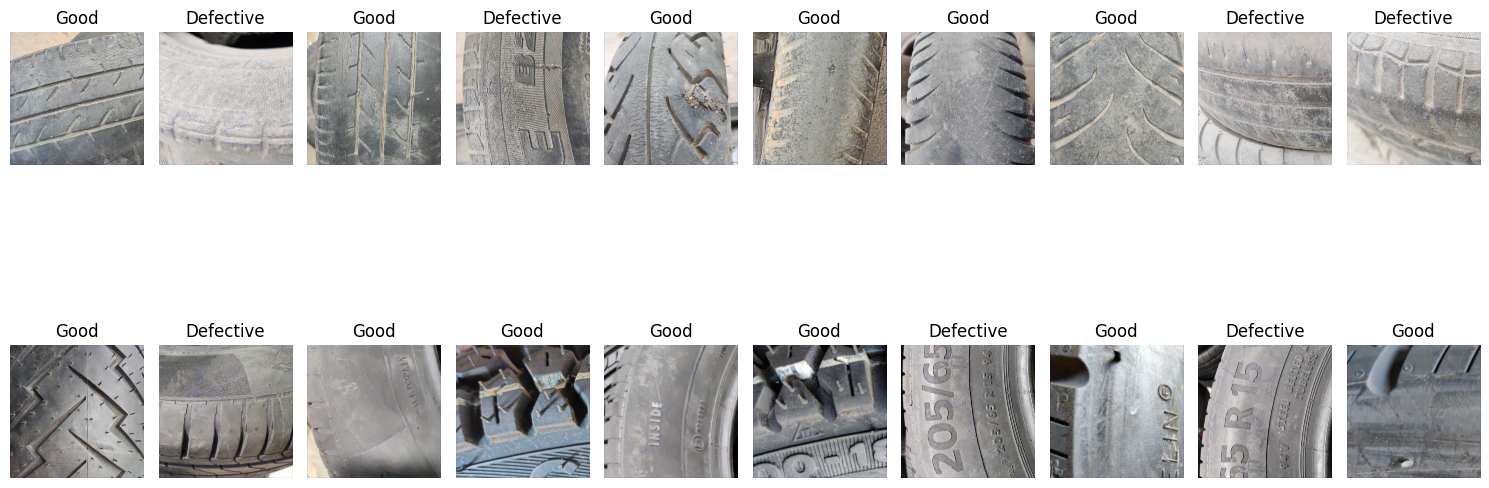

In [10]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\Diat Tire Classification Paper Written\tyre classification using svm\Test image of tyre image"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the tyre region
    segmented_img = segment_tyre(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = svm_model.predict(scaled_features)[0]
    scaled_test_images.append("Defective" if prediction == 1 else "Good")  # Mapping 0 and 1 to Good and Defective

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)

In [11]:
# Defining parameter ranges for different kernels
param_grid = {
    'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'sigmoid']
} 

# Create GridSearchCV object
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, refit=True, verbose=3) 

# Fit the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 147 candidates, totalling 735 fits
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.487 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.487 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.474 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamm

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=3)

[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.769 total time=   1.4s
[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.769 total time=   2.0s
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.868 total time=   1.4s
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.763 total time=   1.2s
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.895 total time=   1.1s
[CV 1/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.821 total time=   0.0s
[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.769 total time=   0.0s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.711 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.711 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.658 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.436 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.615 total time=   0.0s
[CV 3/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=3)

In [12]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
SVC(C=100, gamma=0.0001, kernel='linear', probability=True)


In [13]:
# Get the best hyperparameters and model
best_params = grid.best_params_
best_model = grid.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVM Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params}")

Best SVM Accuracy: 0.81
Best Hyperparameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}


In [14]:
# Model evaluation
y_pred_best = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       0.86      0.75      0.80        24

    accuracy                           0.81        48
   macro avg       0.82      0.81      0.81        48
weighted avg       0.82      0.81      0.81        48



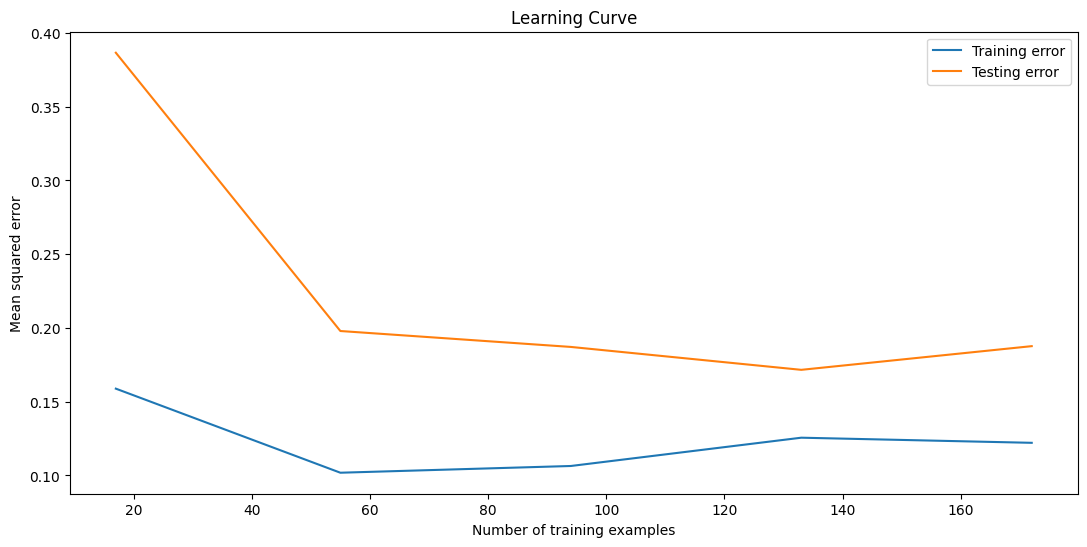

In [15]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate mean training and testing error
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(13, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Testing error')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Learning Curve')
plt.legend()
plt.grid(False)
plt.show()

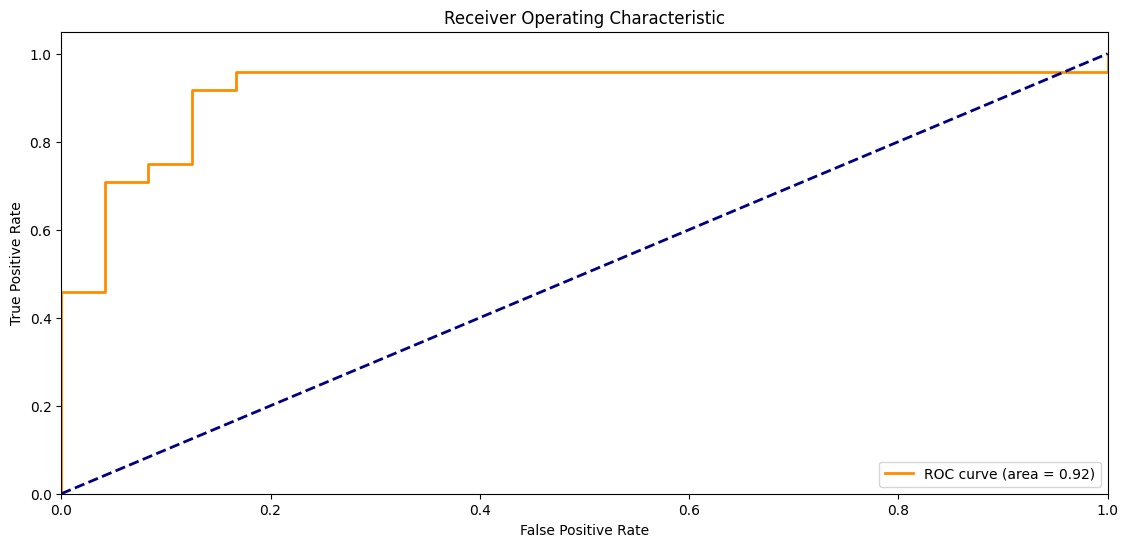

In [16]:
# ROC analysis
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(13.5, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
roc_auc

0.9166666666666667

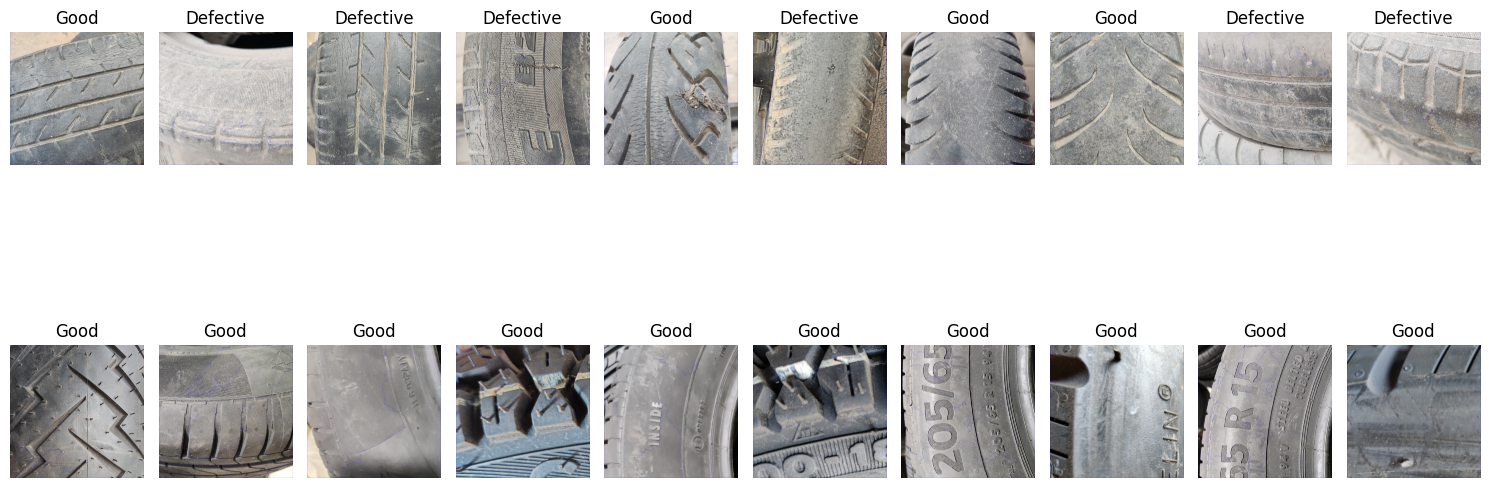

In [18]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\Diat Tire Classification Paper Written\tyre classification using svm\Test image of tyre image"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the tyre region
    segmented_img = segment_tyre(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = best_model.predict(scaled_features)[0]
    scaled_test_images.append("Defective" if prediction == 1 else "Good")  # Mapping 0 and 1 to Good and Defective

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)

SVM Accuracy: 0.6458333333333334
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48



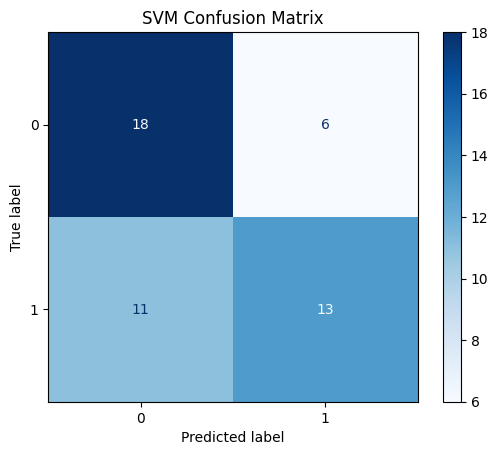

In [27]:
# SVM
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
svm_cm = confusion_matrix(y_test, y_pred_svm)
#ConfusionMatrixDisplay(svm_cm, "SVM")
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()

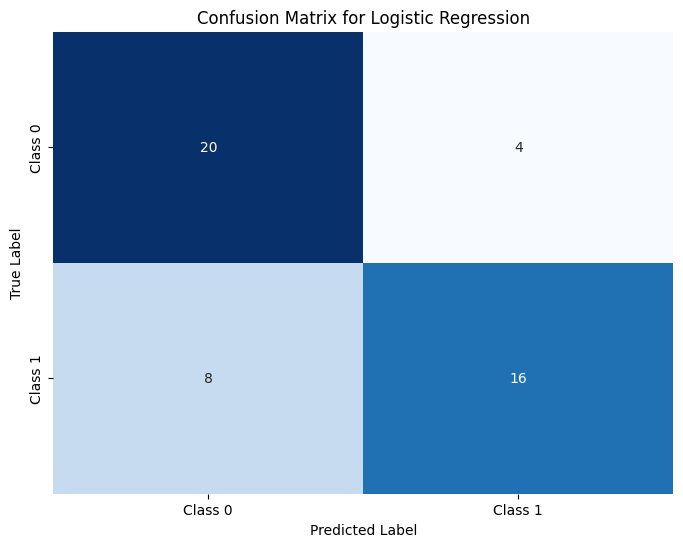

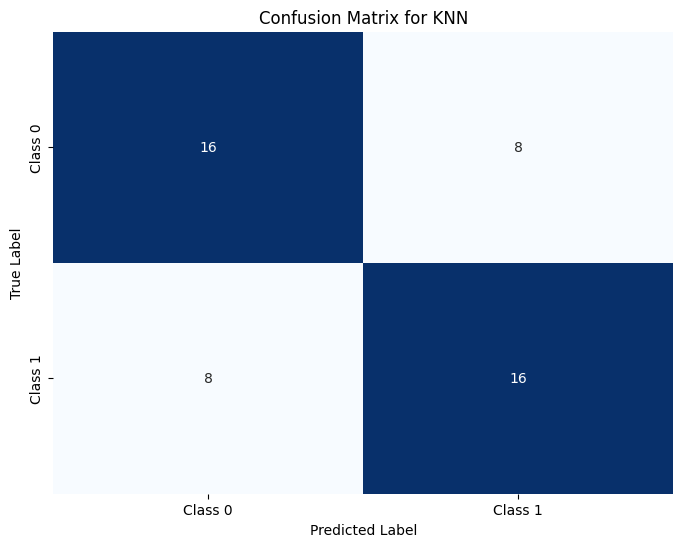

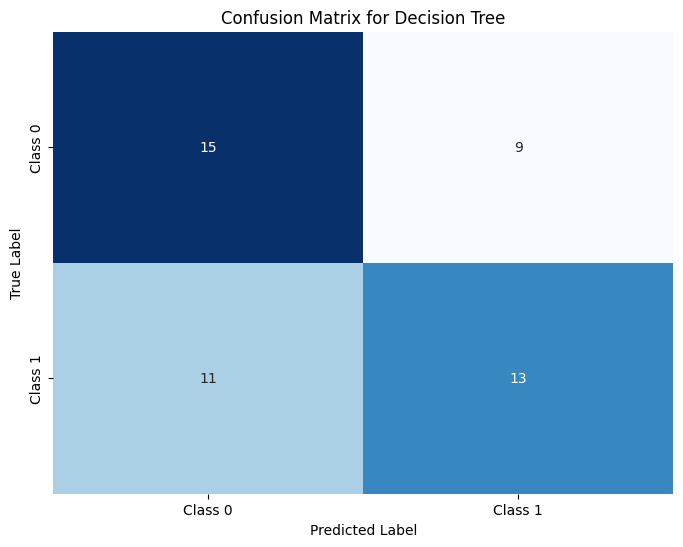

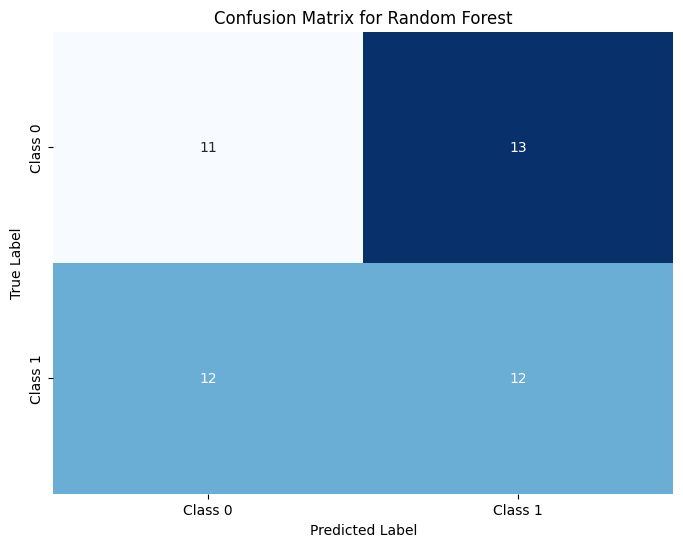

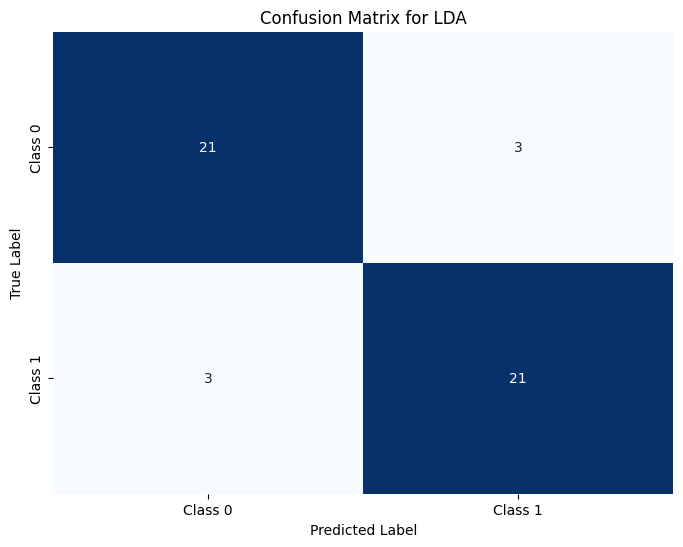

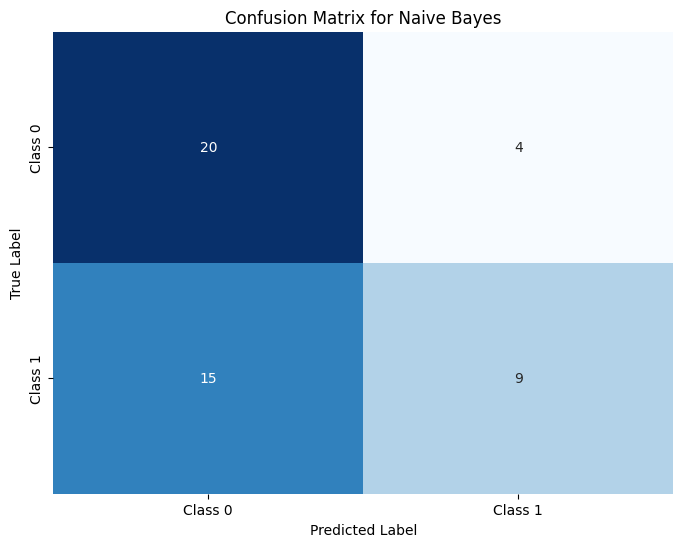

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


logistic_cm = confusion_matrix(y_test, y_pred_logistic)
plot_confusion_matrix(logistic_cm, "Logistic Regression")   

knn_cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(knn_cm, "KNN")

decision_tree_cm = confusion_matrix(y_test, y_pred_decision_tree)
plot_confusion_matrix(decision_tree_cm, "Decision Tree")

random_forest_cm = confusion_matrix(y_test, y_pred_random_forest)
plot_confusion_matrix(random_forest_cm, "Random Forest")

lda_cm = confusion_matrix(y_test, y_pred_lda)
plot_confusion_matrix(lda_cm, "LDA")

naive_bayes_cm = confusion_matrix(y_test, y_pred_naive_bayes)
plot_confusion_matrix(naive_bayes_cm, "Naive Bayes")